<a href="https://colab.research.google.com/github/aquemi/latency_analysis/blob/main/latencies_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Proposta de identificar automaticamente uma degradação (piora) no tempo de resposta de um serviço.

*   Conjunto de dados: temos 24 linhas com as colunas de número do serviço, data de criação, data de atualização, dia e medições de latência por minuto.

> Conteúdo:
1. Importar bibliotecas necessárias e carregar a tabela com os dados;
2. Checar o tipo dos dados, ordená-los e transformá-los para manipulação;
3. Plotar a latência total ao longo do tempo;
4. Verificar se a série temporal segue uma distribuição normal através do teste de Shapiro-Wilk Test;
5. Detectar os outliers (valores com grande aumento na latência) e pegar os índices de cada hora que isso acontece;
6. Discussão gráficos de análise de latência.


#### 1. Importar bibliotecas, carregar a tabela com os dados;

In [230]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from google.colab import drive  
from itertools import chain


In [231]:
drive.mount('/content/drive/',force_remount=True)
table_dir_file = '/content/drive/MyDrive/desafio_latencia/latencies_table.csv'

Mounted at /content/drive/


Leitura da tabela com a biblioteca pandas:

In [232]:
latencies_table = pd.read_csv(table_dir_file)

In [233]:
latencies_table.head(2)

,service,created_at,updated_at,day,latencies
0,12047,2023-03-19 21:00:38.306 -0300,2023-03-19 21:59:38.574 -0300,2023-03-19 21:59:38.339 -0300,"6410,6774,6470,6346,7002,7938,6588,8353,6516,7..."
1,12047,2023-03-19 13:00:38.486 -0300,2023-03-19 13:59:39.271 -0300,2023-03-19 13:59:38.245 -0300,"6481,10298,8093,8685,8917,6827,8025,6632,9610,..."


#### 2. Checar o tipo dos dados, ordená-los e transformá-los;

Verificação do tipo de dado de cada coluna:

In [234]:
latencies_table.dtypes

service        int64
created_at    object
updated_at    object
day           object
latencies     object
dtype: object

Vamos ordenar cronologicamente as medições a partir da coluna *created_at* da seguinte forma:

In [235]:
latencies_table.sort_values(by='created_at', inplace = True) # ordem cronológica
latencies_table.head(2)

,service,created_at,updated_at,day,latencies
1,12047,2023-03-19 13:00:38.486 -0300,2023-03-19 13:59:39.271 -0300,2023-03-19 13:59:38.245 -0300,"6481,10298,8093,8685,8917,6827,8025,6632,9610,..."
9,12047,2023-03-19 14:00:39.101 -0300,2023-03-19 14:59:38.926 -0300,2023-03-19 14:59:38.258 -0300,"7734,22091,6936,9525,6905,34099,9581,10556,101..."


Transforma a coluna latencies de string para int:

In [120]:
latencies_table.latencies[0] # a coluna 'latencies' inicialmente é uma string (frase), de forma que não é possível plotar ou fazer cálculos

'6410,6774,6470,6346,7002,7938,6588,8353,6516,7638,8735,7899,7143,8086,8607,6603,10490,9843,6770,7754,7876,34607,7057,10673,8488,7568,7444,6849,6430,12031,12228,7581,8407,5573,6751,7590,14624,27360,30476,7626,5559,10657,7817,9984,6576,11099,11861,7912,7697,10036,6856,6899,6001,10692,17682,15064,8959,7825,7291,8146'

In [236]:
for i in latencies_table.index: #RangeIndex(start=0, stop=24, step=1)
  latencies_table['latencies'][i] = list(map(int, latencies_table['latencies'][i].split(','))) #separa cada elemento de acordo com a vírgula e transforma em inteiros

In [237]:
latencies_table.latencies

1     [6481, 10298, 8093, 8685, 8917, 6827, 8025, 66...
9     [7734, 22091, 6936, 9525, 6905, 34099, 9581, 1...
13    [6895, 6169, 8580, 11341, 7138, 9519, 8547, 84...
3     [9952, 19955, 11971, 20456, 10129, 8323, 10520...
16    [9303, 13127, 5800, 12859, 6691, 8567, 7123, 1...
8     [8954, 8204, 6565, 10183, 7666, 8494, 7380, 67...
14    [6303, 7278, 5815, 6662, 6232, 9514, 7406, 129...
10    [8005, 7064, 7229, 6917, 6135, 5079, 45655, 83...
0     [6410, 6774, 6470, 6346, 7002, 7938, 6588, 835...
5     [8507, 10464, 6946, 8164, 8388, 9984, 6846, 77...
12    [10026, 8915, 7465, 8251, 7895, 8326, 9672, 13...
22    [8981, 7870, 6984, 15243, 8222, 7432, 7966, 68...
15    [9919, 7299, 6507, 10793, 10495, 8516, 7455, 7...
20    [8509, 7039, 13420, 8154, 9421, 6475, 12394, 8...
11    [53611, 58904, 19664, 9966, 8644, 7320, 14324,...
18    [8130, 7447, 9912, 7516, 8284, 7401, 5986, 747...
6     [7474, 6575, 6071, 9298, 7364, 8095, 7679, 801...
7     [6814, 5977, 7185, 6573, 8049, 8660, 7639,

#### 3. Plotar latência ao longo do tempo: apenas para visualização e exploração do conjunto de dados

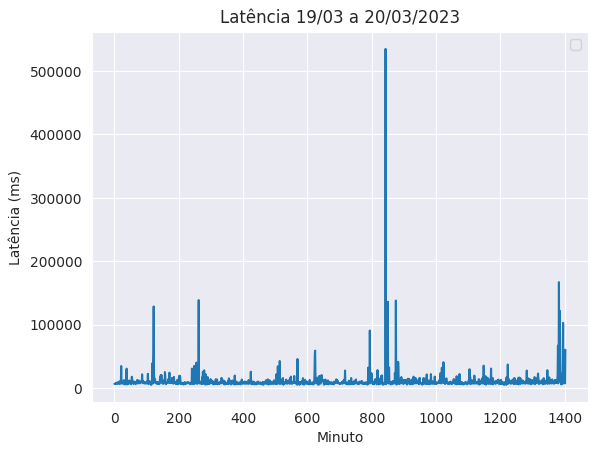

In [238]:
total_med = [] # a variável total_med armazena todas as medições de latência do conjunto de dados
for i in range(len(latencies_table)):
  total_med.append(latencies_table['latencies'][i])

total_med = list(chain.from_iterable(total_med)) # cria uma lista com todas as medições
x = np.arange(len(total_med)) # x é a variável que contém o tamanho

fig = plt.figure()
plt.plot(x,total_med, linestyle="-")

plt.legend()
plt.xlabel('Minuto')
plt.ylabel('Latência (ms)')
plt.title("Latência do período de 19/03 a 20/03/2023")
plt.show()

In [355]:
arr = np.array([total_med])
mean_tot = np.mean(arr)
std_tot = np.std(arr),
print('Valor mínimo de latência(ms):',np.min(arr),
      'Valor máximo de latência(ms):',np.max(arr))

Valor mínimo de latência(ms): 4791 Valor máximo de latência(ms): 535032


In [357]:
print('Média da latência durante 1 dia:',mean_tot,', Desvio padrão:',std_tot)

Média da latência durante 1 dia: 10727.07982893799 , Desvio padrão: (17616.191160408147,)


#### 4. Para detectarmos valores de alta latência, devemos verificar se a série temporal segue uma distribuição normal ou não e em seguida utilizar a abordagem mais adequada. Para isso, podemos utilizar o teste de Shapiro-Wilk:


In [240]:
from scipy.stats import shapiro

# conduct the  Shapiro-Wilk Test
shapiro(total_med)

ShapiroResult(statistic=0.16393673419952393, pvalue=0.0)

A hipótese nula do teste de Shapiro-Wilk é que a população possui distribuição normal. Portanto, um valor de p < 0.05 indica que podemos rejeitar a hipótese nula, ou seja, os dados não possuem distribuição normal.

#### 5. Como não temos uma distribuição normal dos dados, vamos determinar os valores que diferem do conjunto de medições coletados através da análise de boxplot. Dessa forma iremos detectar os valores com grande aumento na latência (outliers) para cada hora, o que indica uma piora no tempo de resposta do serviço.


In [312]:
outliers=[]
for i in latencies_table.index:
  arr_box = np.array([latencies_table.latencies[i]])
  # encontrando o primeiro quartil
  q1 = np.quantile(arr_box, 0.25)
 
  # encontrando o terceiro quartil
  q3 = np.quantile(arr_box, 0.75)
  med = np.median(arr_box)
 
  # encontrando a região interquartil
  iqr = q3-q1
 
  # encontrando o limite superior e o inferior
  upper_bound = q3+(1.5*iqr)
  lower_bound = q1-(1.5*iqr)
  #print(iqr, upper_bound, lower_bound)

for i in latencies_table.index: #pegamos os índices que temos os valores de latência maior que o limite superior (outliers)
  outliers.append([index for (index, item) in enumerate(latencies_table['latencies'][i]) if item >= upper_bound]) 

Aqui temos os índices dos outliers para cada hora:

In [313]:
outliers 

[[44, 58],
 [5, 11],
 [46, 51, 56],
 [14, 28],
 [],
 [],
 [15, 40, 44, 47, 50, 51],
 [6],
 [21, 37, 38],
 [12, 16],
 [34],
 [34],
 [9, 12, 19, 20],
 [8],
 [0, 1],
 [],
 [],
 [41],
 [38, 45, 52, 58, 59],
 [1, 45],
 [0, 59],
 [30, 31, 35, 38, 40],
 [3, 35, 36, 39, 42, 44, 51, 52, 55, 59],
 [0, 1, 2, 3]]

In [297]:
latencies_table['outliers_indices'] = outliers

In [304]:
latencies_table.head(2)

,service,created_at,updated_at,day,latencies,outliers_indices
1,12047,2023-03-19 13:00:38.486 -0300,2023-03-19 13:59:39.271 -0300,2023-03-19 13:59:38.245 -0300,"[6481, 10298, 8093, 8685, 8917, 6827, 8025, 66...","[44, 58]"
9,12047,2023-03-19 14:00:39.101 -0300,2023-03-19 14:59:38.926 -0300,2023-03-19 14:59:38.258 -0300,"[7734, 22091, 6936, 9525, 6905, 34099, 9581, 1...","[5, 11]"


No gráfico abaixo podemos observar dois picos de latência, acima de 30 segundos, que ocorreram das 14h às 14h59, no dia 19/03/2023.

#### 6. Discussão gráficos de análise de latência.

Na figura abaixo temos um gráfico que ilustra o tempo de resposta de acordo com cada minuto, no período das 14h até 14h59, do dia 19/03/2023. Na marcação representada por um losango, podemos observar dois picos de latência, acima de 30 segundos. 

0 5
1 11


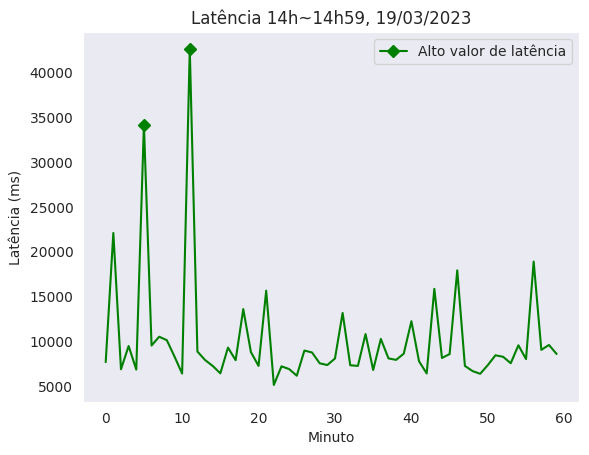

In [326]:
fig = plt.figure()
markers_on = latencies_table["outliers_indices"][9]
plt.plot(latencies_table["latencies"][9], '-gD', markevery=markers_on, linestyle="-",label='Alto valor de latência')

for i, v in enumerate(markers_on):
  print(i,v)
  plt.annotate(str(v), xy=(i,v),  textcoords='offset points')

plt.grid()
plt.legend()
plt.xlabel('Minuto')
plt.ylabel('Latência (ms)')
plt.title("Latência 14h~14h59, 19/03/2023")
plt.show()

De acordo com o gráfico abaixo, podemos ver a quantidade de vezes que aconteceu um aumento da latência a cada hora, durante 24h. A maior quantidade aconteceu por volta das 11h. Podemos fazer a mesma análise para uma quantidade maior de dados históricos para verificar se isso é recorrente.

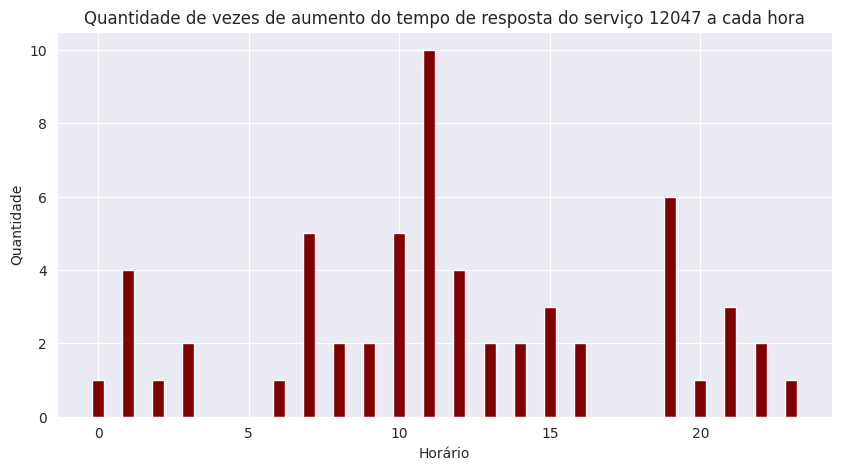

In [352]:
import numpy as np
import matplotlib.pyplot as plt
 
fig = plt.figure(figsize = (10, 5))
dat = pd.date_range(latencies_table['created_at'][1],periods=24,freq='1H')

plt.bar(dat.hour, latencies_table['qtd_falhas'], color ='maroon', width = 0.4)

plt.xlabel("Horário")
plt.ylabel("Quantidade")
plt.title("Quantidade de vezes de aumento da latência do serviço 12047 a cada hora")
plt.show()

In [350]:
latencies_table.to_csv('latencies_outliers.csv') #exportando os dados para análises futuras

Obrigada pela sua atenção ao acompanhar esta análise.